In [3]:
#Read in the data from the files.
from mnist import MNIST
import numpy as np
mndata = MNIST('../../HW1/mnist')

trainData, trainLabel = mndata.load_training()

testData, testLabel = mndata.load_testing()

trainData = np.asarray(trainData)
testData = np.asarray(testData)
trainLabel = np.asarray(trainLabel)[:, np.newaxis]
testLabel = np.asarray(testLabel)[:, np.newaxis]

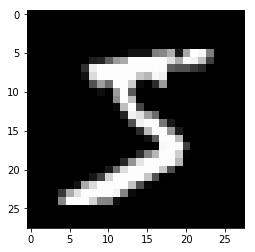

In [4]:
#Show a templete of digits.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time


img = np.reshape(trainData[0],(28,28))
plt.figure()
plt.imshow(img, cmap=cm.gray)
plt.show()

In [25]:
# Process the range of pixel value to [-1..1]
xTrain = trainData / 127.5 - 1
yTrain = trainLabel

xTest = testData / 127.5 - 1
yTest = testLabel

# tack on a "1" at the beginning for a bias parameter
biasTrain = np.ones(len(xTrain))[:, np.newaxis]
biasTest = np.ones(len(xTest))[:, np.newaxis]
xTrain = np.concatenate((biasTrain,xTrain), axis=1)
xTest = np.concatenate((biasTest,xTest), axis=1)

# Logistic Regression via Gradient Descent

In [37]:
# Define data extraction function
def dataExtract(data, label, target1, target2):
    indexTg1 = np.where(label == target1)[0]
    dataTg1 = data[indexTg1]
    labelTg1 = np.ones(len(indexTg1))[:,np.newaxis]
    indexTg2 = np.where(label == target2)[0]
    dataTg2 = data[indexTg2]
    labelTg2 = np.zeros(len(indexTg2))[:,np.newaxis]
    dataEx = np.concatenate((dataTg1,dataTg2), axis = 0)
    labelEx = np.concatenate((labelTg1,labelTg2), axis = 0)
    return dataEx, labelEx

xTrain28, yTrain28 = dataExtract(xTrain, yTrain, 2, 8)
xTest28, yTest28 = dataExtract(xTest, yTest, 2, 8)

In [66]:
from sklearn.model_selection import train_test_split

def sigmoid(x):
    return 1.0 / (1 + np.exp(-x))

def calculateLossLR(data, label, weight, lam):
    E = -1.0 * np.mean(label * np.log(sigmoid(np.dot(data, weight)))\
                         + (1 - label) * np.log(1 - sigmoid(np.dot(data, weight))))
    C = np.sum(np.power(weight, 2))
    loss = E + lam * C
    return loss

def logisticRegression(trainData, trainLabel, lr = 1e-3, maxIter = 500, T = 2e8, lam = 1e-3, batchSize = 1):
    trainD, validD, trainL, validL = train_test_split(trainData, trainLabel, test_size=0.1, random_state=42)        
    w_0 = np.zeros((len(trainD[0]), 1))
    it = 0
    while it <= maxIter:
        lr1 = lr / (1.0 + it / T)
        for startInd in range(0, len(trainData) - batchSize + 1, batchSize):
            trainDBatch = trainD[startInd : startInd + batchSize]
            trainLBatch = trainL[startInd : startInd + batchSize]
            derE = np.mean((sigmoid(np.dot(trainDBatch, w_0)) - trainLBatch) \
                          * trainDBatch, axis = 0)[:, np.newaxis]
            derC = 2.0 * np.sum(w_0)
            derJ = derE + lam * derC
            w_0 -= lr1 * derJ
        loss = calculateLossLR(validD, validL, w_0, lam)
        if it % 100 == 0:
            print(loss)
        it += 1
    return w_0

In [73]:
weight = logisticRegression(xTrain28, yTrain28, 1.5e-2, 1000, lam = 1e-4, batchSize = int(len(xTrain28) / 10))

0.429911105598
0.0844853103409
0.0793186686404
0.0777809370218
0.0771583228958
0.0768908884076
0.0767985002534
0.0768065973458
0.0768783603732
0.0769931182047
0.0771381333187


In [74]:
def pecisionRate(data, label, weight):
    pred = sigmoid(np.dot(data, weight))
    pred[pred >= 0.5] = 1
    pred[pred < 0.5] = 0
    rate = 1.0 * np.sum([a == b for (a, b) in zip(pred, label)]) / len(label)
    return rate

acc = pecisionRate(xTest28, yTest28, weight)
acc

0.98055832502492524

In [69]:
from sklearn.model_selection import train_test_split
def calculateLoss(data, label, weight, lam):
    a = data.dot(weight)
    y = np.exp(a) / np.sum(np.exp(a), axis=1)[:, np.newaxis]
    E = -1.0 * np.mean(label * np.log(y))
    C = np.sum(np.power(weight, 2))
    loss = E + lam * C
    return loss

def oneHot(label):
    labelHot = np.zeros((len(label),len(np.unique(label))))
    for i in range(len(label)):
        labelHot[i,label[i]] = 1
    return labelHot

def softmaxRegression(trainData, trainLabel, lr = 1e-4, maxIter = 500, T = 2e8, lam = 1e-3, batchSize = 1):
    classNum = len(np.unique(trainLabel))
    trainLabel = oneHot(trainLabel)
    trainD, validD, trainL, validL = train_test_split(trainData, trainLabel, test_size=0.1, random_state=42)    
    w_0 = np.zeros((len(trainData[0]), classNum))
    it = 0    
    while it <= maxIter:
        lr1 = lr / (1.0 + it / T)
        # Gradient Descent
        for startInd in range(0, len(trainData) - batchSize + 1, batchSize):
            trainDBatch = trainD[startInd : startInd + batchSize]
            trainLBatch = trainL[startInd : startInd + batchSize]
            a = trainDBatch.dot(w_0)
            y = np.exp(a) / np.sum(np.exp(a), axis=1)[:, np.newaxis]
            y = y - trainLBatch        
            derE = 1.0 * trainDBatch.T.dot(y) / batchSize
            derC = 2.0 * np.sum(w_0)
            derJ = derE + lam * derC
            w_0 -= lr1 * derJ
        lossV = calculateLoss(validD, validL, w_0, lam)
        if it % 100 == 0:
            print (lossV)
        it += 1
    print ('done')
    return w_0

In [63]:
weight = softmaxRegression(xTrain, yTrain, 1.75e-1, 700, lam = 1e-4, batchSize = int(len(xTrain) / 10))

1.44450540388
0.0337977770761
0.033913156151
0.0446888522617
0.035740750449
0.0368835198606
0.0660028793269
0.0381598880233
done


In [64]:
def pecisionRate(data, label, weight):
    correct = 0
    label = oneHot(label)
    for i in range(len(data)):
        a = data[i][np.newaxis,:].dot(weight)
        y = (np.exp(a) / np.sum(np.exp(a)))[0]
        prediction = np.where(y == np.max(y))[0][0]
        if label[i, prediction] == 1:
            correct += 1
    rate = 1.0 * correct / len(label)
    return rate

In [65]:
yTeHot = oneHot(yTest)
acc = pecisionRate(xTest, yTest, weight)
acc

0.9239